# Finetuning F&B
F&B is a Sentiment Analysis dataset with 3 possible labels: `positive`, `negative`, and `neutral`

In [1]:
import os, sys
sys.path.append('../')
os.chdir('../')

import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

from utils.forward_fn import forward_sequence_classification
from utils.metrics import document_sentiment_metrics_fn
from utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

d:\coding\python\indonlu\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [3]:
# Set random seed
set_seed(26092020)

In [4]:
import torch
import transformers

print(torch.__version__)
print(transformers.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
4.46.3
True


# Load Model

In [5]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p2')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [7]:
count_param(model)

124443651

# Prepare Dataset

In [8]:
train_dataset_path = './dataset/fnb/food_quality/train_preprocess.csv'
valid_dataset_path = './dataset/fnb/food_quality/valid_preprocess.csv'
test_dataset_path = './dataset/fnb/food_quality/test_preprocess_masked_label.csv'
test_valid_dataset_path = './dataset/fnb/food_quality/test_preprocess.csv'

In [9]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)
test_valid_dataset = DocumentSentimentDataset(test_valid_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=128, batch_size=8, num_workers=0, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=128, batch_size=8, num_workers=0, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=128, batch_size=8, num_workers=0, shuffle=False)
test_valid_loader = DocumentSentimentDataLoader(dataset=test_valid_dataset, max_seq_len=128, batch_size=8, num_workers=0, shuffle=False)

In [10]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


# Test model on sample sentences

In [11]:
text = 'Mie goreng terenak yang pernah saya makan tapi mahal dan pelayanan tidak bagus'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Mie goreng terenak yang pernah saya makan tapi mahal dan pelayanan tidak bagus | Label : negative (36.708%)


In [12]:
text = 'harganya murah banget tapi rasanya biasa aja'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: harganya murah banget tapi rasanya biasa aja | Label : negative (42.599%)


In [13]:
text = 'gak akan balik kesini lagi makanannya enak banget sampai buat sakit perut'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: gak akan balik kesini lagi makanannya enak banget sampai buat sakit perut | Label : negative (43.699%)


# Fine Tuning & Evaluation

In [14]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

2.5.1+cu121
CUDA available: True
CUDA version: 12.1


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=3e-6)
model = model.to(device)

In [17]:
print("Model embedding device:",
      model.bert.embeddings.word_embeddings.weight.device)

Model embedding device: cuda:0


In [18]:
import os
import torch
from tqdm import tqdm

# =========================
# KONFIGURASI
# =========================
n_epochs = 5
save_dir = "best_model_price"   # ganti sesuai aspek
os.makedirs(save_dir, exist_ok=True)

best_valid_loss = float("inf")

# =========================
# TRAINING LOOP
# =========================
for epoch in range(n_epochs):

    # =========================
    # TRAINING
    # =========================
    model.train()
    total_train_loss = 0
    train_preds, train_labels = [], []

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} TRAIN")

    for batch_data in train_pbar:
        optimizer.zero_grad()

        loss, batch_pred, batch_label = forward_sequence_classification(
            model=model,
            batch_data=batch_data,
            device=device
        )

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_preds.extend(batch_pred)
        train_labels.extend(batch_label)

        train_pbar.set_postfix({
            "loss": f"{total_train_loss / (len(train_preds)//len(batch_pred)):.4f}",
            "lr": f"{get_lr(optimizer):.2e}"
        })

    train_metrics = document_sentiment_metrics_fn(train_preds, train_labels)

    print(
        f"(Epoch {epoch+1}) "
        f"TRAIN LOSS: {total_train_loss / len(train_loader):.4f} "
        f"{metrics_to_string(train_metrics)} "
        f"LR:{get_lr(optimizer):.2e}"
    )

    # =========================
    # VALIDATION
    # =========================
    model.eval()
    total_valid_loss = 0
    valid_preds, valid_labels = [], []

    with torch.no_grad():
        valid_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1} VALID")

        for batch_data in valid_pbar:
            loss, batch_pred, batch_label = forward_sequence_classification(
                model=model,
                batch_data=batch_data,
                device=device
            )

            total_valid_loss += loss.item()
            valid_preds.extend(batch_pred)
            valid_labels.extend(batch_label)

            valid_pbar.set_postfix({
                "loss": f"{total_valid_loss / (len(valid_preds)//len(batch_pred)):.4f}"
            })

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_metrics = document_sentiment_metrics_fn(valid_preds, valid_labels)

    print(
        f"(Epoch {epoch+1}) "
        f"VALID LOSS: {avg_valid_loss:.4f} "
        f"{metrics_to_string(valid_metrics)}"
    )

    # =========================
    # SIMPAN MODEL TERBAIK
    # =========================
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss

        print(
            f"✔ Model terbaik disimpan "
            f"(Epoch {epoch+1}, VALID LOSS={best_valid_loss:.4f})"
        )

        model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)

print("\nTraining selesai.")
print(f"Model terbaik tersimpan di folder: {save_dir}")

Epoch 1 TRAIN: 100%|██████████| 273/273 [01:53<00:00,  2.42it/s, loss=0.7126, lr=3.00e-06]


(Epoch 1) TRAIN LOSS: 0.7126 ACC:0.69 F1:0.69 REC:0.69 PRE:0.70 LR:3.00e-06


Epoch 1 VALID: 100%|██████████| 59/59 [00:03<00:00, 19.33it/s, loss=0.2258]


(Epoch 1) VALID LOSS: 0.4478 ACC:0.81 F1:0.81 REC:0.81 PRE:0.82
✔ Model terbaik disimpan (Epoch 1, VALID LOSS=0.4478)


Epoch 2 TRAIN: 100%|██████████| 273/273 [01:00<00:00,  4.52it/s, loss=0.4303, lr=3.00e-06]


(Epoch 2) TRAIN LOSS: 0.4303 ACC:0.83 F1:0.83 REC:0.83 PRE:0.83 LR:3.00e-06


Epoch 2 VALID: 100%|██████████| 59/59 [00:03<00:00, 19.42it/s, loss=0.2034]


(Epoch 2) VALID LOSS: 0.4033 ACC:0.85 F1:0.85 REC:0.85 PRE:0.87
✔ Model terbaik disimpan (Epoch 2, VALID LOSS=0.4033)


Epoch 3 TRAIN: 100%|██████████| 273/273 [01:01<00:00,  4.44it/s, loss=0.3237, lr=3.00e-06]


(Epoch 3) TRAIN LOSS: 0.3237 ACC:0.88 F1:0.88 REC:0.88 PRE:0.88 LR:3.00e-06


Epoch 3 VALID: 100%|██████████| 59/59 [00:03<00:00, 19.36it/s, loss=0.1698]


(Epoch 3) VALID LOSS: 0.3368 ACC:0.86 F1:0.86 REC:0.86 PRE:0.86
✔ Model terbaik disimpan (Epoch 3, VALID LOSS=0.3368)


Epoch 4 TRAIN: 100%|██████████| 273/273 [01:01<00:00,  4.46it/s, loss=0.2436, lr=3.00e-06]


(Epoch 4) TRAIN LOSS: 0.2436 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92 LR:3.00e-06


Epoch 4 VALID: 100%|██████████| 59/59 [00:03<00:00, 19.43it/s, loss=0.1730]


(Epoch 4) VALID LOSS: 0.3431 ACC:0.87 F1:0.87 REC:0.87 PRE:0.87


Epoch 5 TRAIN: 100%|██████████| 273/273 [01:01<00:00,  4.44it/s, loss=0.1704, lr=3.00e-06]


(Epoch 5) TRAIN LOSS: 0.1704 ACC:0.95 F1:0.95 REC:0.95 PRE:0.95 LR:3.00e-06


Epoch 5 VALID: 100%|██████████| 59/59 [00:03<00:00, 19.13it/s, loss=0.1876]

(Epoch 5) VALID LOSS: 0.3720 ACC:0.86 F1:0.86 REC:0.86 PRE:0.86

Training selesai.
Model terbaik tersimpan di folder: best_model_price


TEST EVALUATION: 100%|██████████| 59/59 [00:03<00:00, 18.33it/s]
d:\coding\python\indonlu\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\coding\python\indonlu\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\coding\python\indonlu\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

Classification Report:

              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         0
     neutral     1.0000    0.3220    0.4871       469
    positive     0.0000    0.0000    0.0000         0

    accuracy                         0.3220       469
   macro avg     0.3333    0.1073    0.1624       469
weighted avg     1.0000    0.3220    0.4871       469



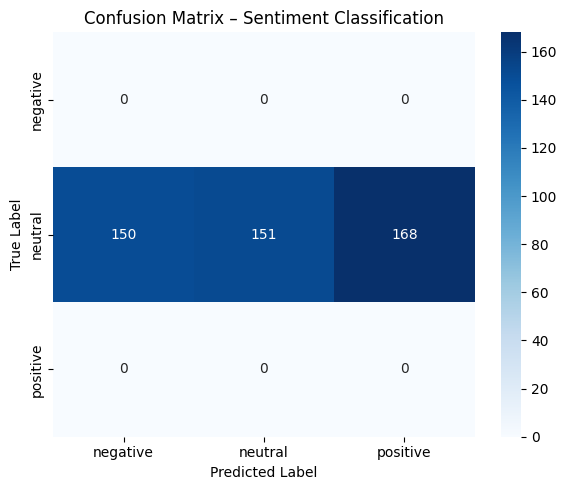

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# EVALUATION
# =========================
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    pbar = tqdm(test_loader, desc="TEST EVALUATION")
    for batch_data in pbar:
        _, batch_hyp, batch_label = forward_sequence_classification(
            model=model,
            batch_data=batch_data,
            device=device
        )
        y_pred.extend(batch_hyp)
        y_true.extend(batch_label)

# =========================
# METRICS
# =========================
label_names = ['negative', 'neutral', 'positive']

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=label_names,
    digits=4
))

# =========================
# VISUALIZATION
# =========================
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Sentiment Classification")
plt.tight_layout()
plt.show()

# Test fine-tuned model on sample sentences

In [20]:
text = 'Mie goreng terenak yang pernah saya makan tapi mahal dan pelayanan tidak bagus'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Mie goreng terenak yang pernah saya makan tapi mahal dan pelayanan tidak bagus | Label : negative (95.964%)


In [21]:
text = 'harganya murah banget tapi rasanya biasa aja'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: harganya murah banget tapi rasanya biasa aja | Label : neutral (62.282%)


In [22]:
text = 'gak akan balik kesini lagi makanannya enak banget sampai buat sakit perut'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: gak akan balik kesini lagi makanannya enak banget sampai buat sakit perut | Label : positive (99.628%)
